In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('News.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
df = pd.read_csv('News.csv', index_col=0)

In [5]:
df.head(2)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0


In [6]:
df.shape

(44919, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44919 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44919 non-null  object
 1   text     44919 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44919 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [8]:
df['class'].unique()

array([0, 1])

In [9]:
df['class'].value_counts()

class
0    23502
1    21417
Name: count, dtype: int64

In [10]:
df = df.drop(['title', 'date', 'subject'], axis=1) # remove unnecessary columns because they are not helpful in identifying fake news

In [11]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [12]:
# Shuffle the DataFrame rows
df = df.sample(frac=1).reset_index(drop=True)

<Axes: xlabel='class', ylabel='count'>

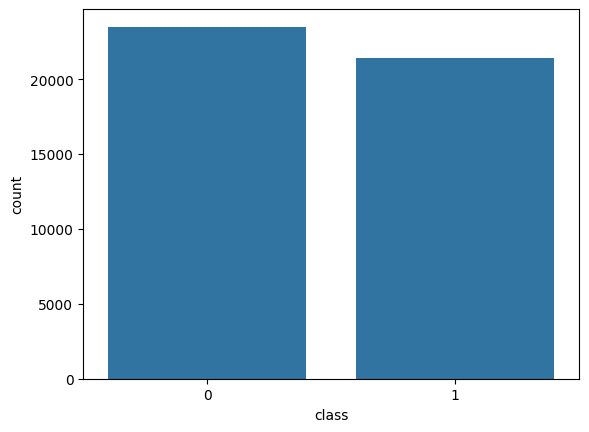

In [13]:
sns.countplot(data=df, x='class', order=df['class'].value_counts().index)

In [15]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

In [16]:
def preprocess_text(text_data):
    preprocessed_text = []
    
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text

In [18]:
preprocessed_review = preprocess_text(df['text'].values)
df['text'] = preprocessed_review

100%|██████████| 44919/44919 [1:58:46<00:00,  6.30it/s]  


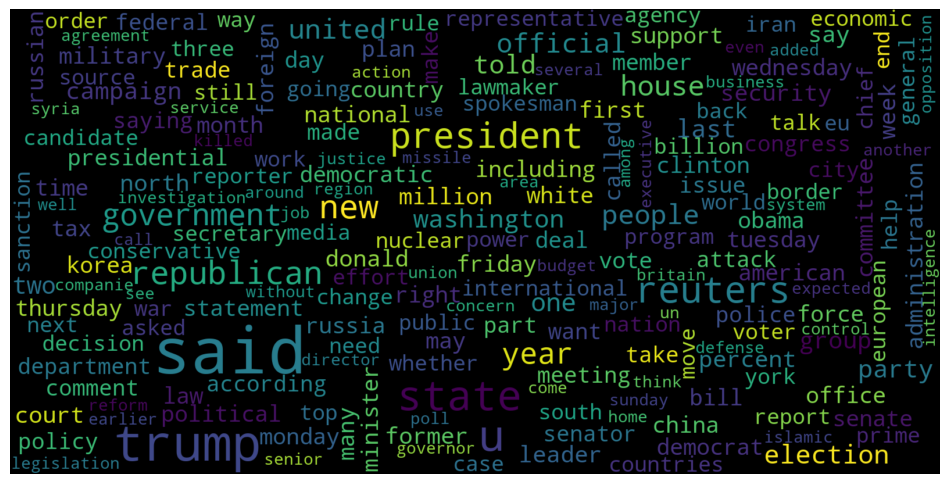

In [19]:
# Real
consolidated = ' '.join(
    word for word in df['text'][df['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(12, 8))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

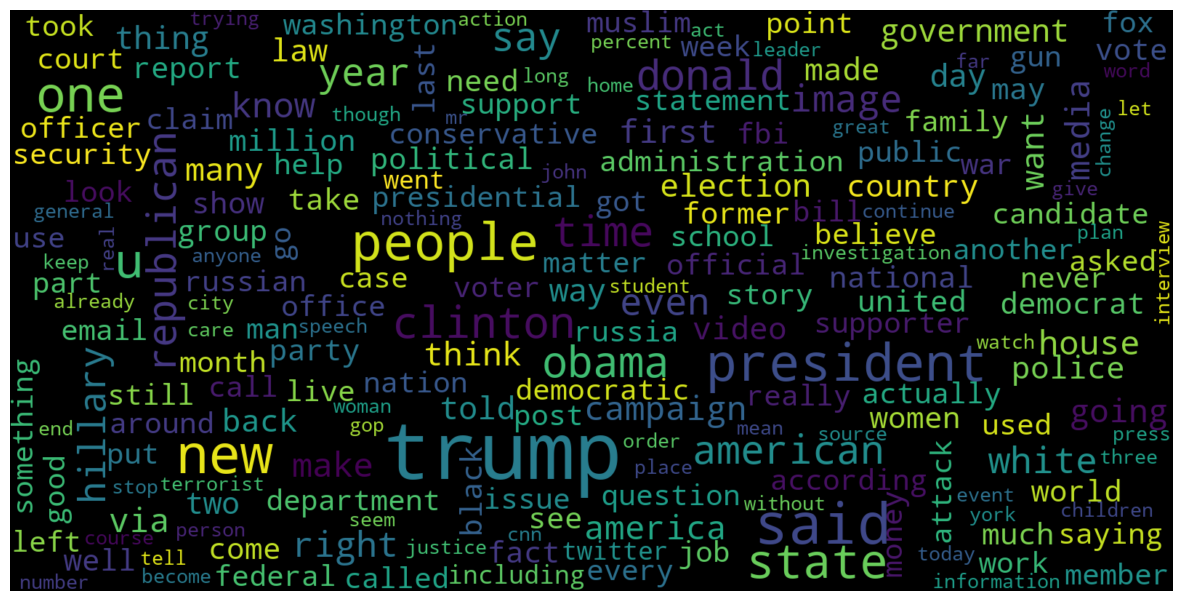

In [20]:
# Fake
consolidated = ' '.join(
    word for word in df['text'][df['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

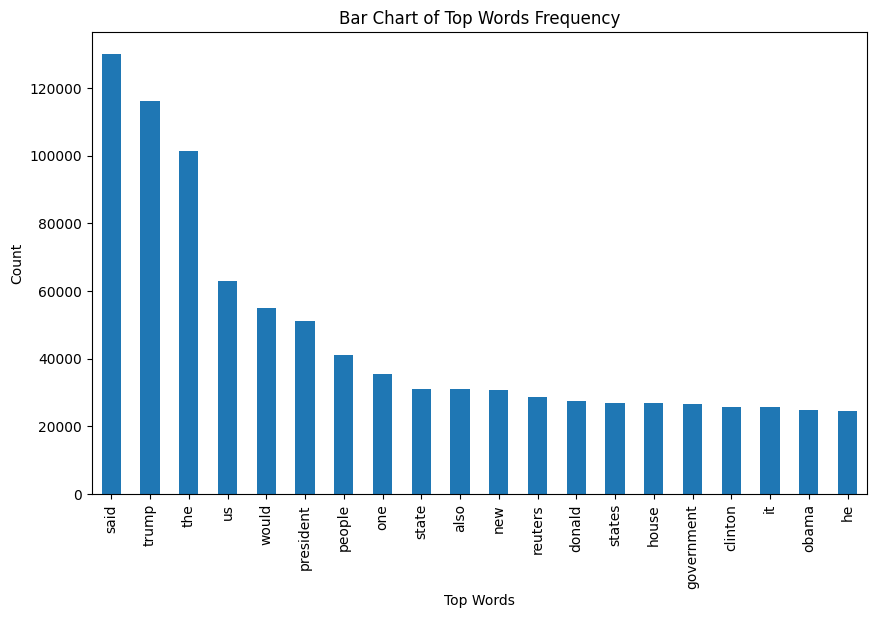

In [22]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df['text'],df['class'], test_size=0.2, random_state=42) 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9938778349798247
0.990093499554764


## Decision Trees

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.999972171977181
0.9967720391807658


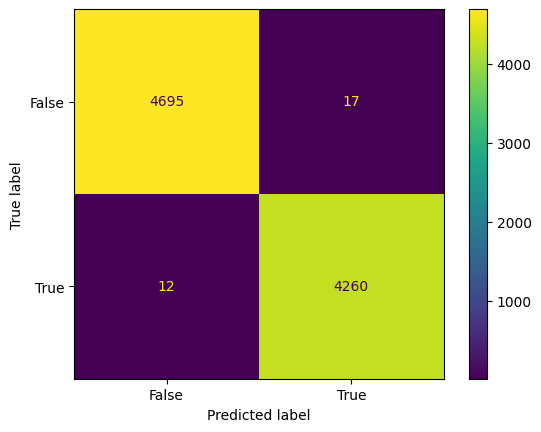

In [31]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()